In [80]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [123]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [100]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, inspect

from flask import Flask, jsonify

In [110]:
# Define the file path
file_path = '/Users/nathancabrera/Documents/sqlalchemy-challenge/Resources/hawaii.sqlite'

In [124]:
# create engine to hawaii.sqlite
engine = create_engine(f'sqlite:///{file_path}')

In [112]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [113]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [114]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [128]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Precipitation Analysis

In [129]:
# Find the most recent date in the data set.
latest_date_query = session.query(func.max(Measurement.date)).scalar()
latest_date = dt.datetime.strptime(latest_date_query, '%Y-%m-%d').date()

print(latest_date)

2017-08-23


In [130]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
first_row = session.query(Measurement).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fdf566c01c0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [131]:
# Visualize Station first set of data as a dictionary
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fdf5659e700>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

In [133]:
# Convert Measurement into Pandas DataFrame
measurement_df = pd.read_sql("SELECT * FROM Measurement", conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [134]:
# Calculate the date one year from the last date in data set.
latest_date = dt.date(2017, 8 ,23)
a_year_ago = latest_date - dt.timedelta(days=365)
a_year_ago

datetime.date(2016, 8, 23)

In [140]:
# Perform a query to retrieve the data and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(a_year_ago, latest_date)).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_prcp_df = pd.DataFrame(date_prcp).set_index("date")

# Sort the dataframe by date
date_prcp_df = date_prcp_df.sort_values("date")


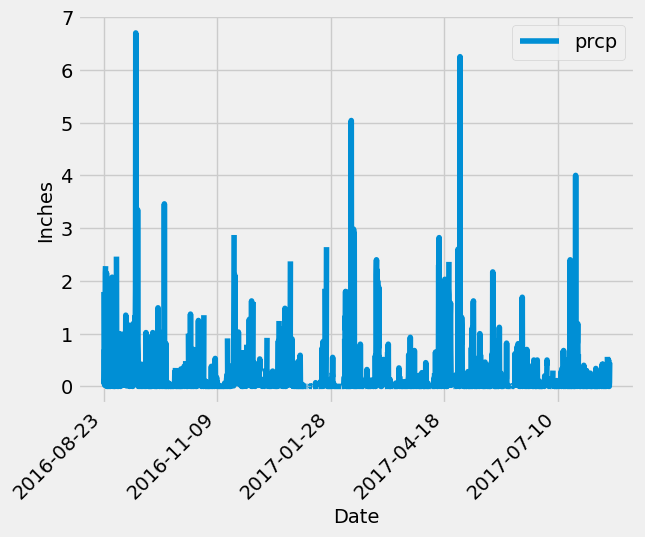

In [142]:
# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_df.plot(y = "prcp")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation = 45, horizontalalignment = "right")
plt.show()

In [143]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [144]:
# Design a query to calculate the total number of stations in the dataset
station_number = session.query(distinct(Measurement.station)).count()
station_number

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [145]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [146]:
print(f"The most active station is {active_stations[0][0]}.")

The most active station is USC00519281.


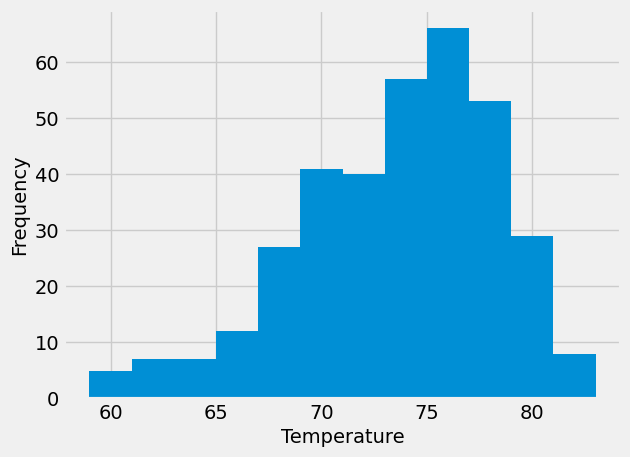

In [147]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date.between(a_year_ago, latest_date)).all()
date_tobs_df = pd.DataFrame(date_tobs).set_index("date")
plt.hist(date_tobs_df["tobs"], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [148]:
# Close Session
session.close()